In [1]:
# import packages 
import numpy as np 

import h5py
import os
import re

from scipy import stats
from scipy import signal
import scipy.optimize

import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import matplotlib as mpl
import matplotlib.cm as mpl_cm
import matplotlib.colors as mpl_colors
import matplotlib.offsetbox as mpl_offsetbox
import matplotlib.gridspec as mpl_gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "Arial"
# mpl.rcParams.update({'font.size': 6.5})
mpl.rcParams.update({'font.size': 8})

print(mpl.rcParams['font.family'])
print(mpl.rcParams['font.sans-serif'])
print(mpl.rcParams['font.size'])

['Arial']
['Arial']
8.0


In [5]:
# Save progress 
HISTORY_FILEPATH = r"\\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\JEDI2PTraceFFTsMakeFigs_Ver01.py"
LAST_SAVE_TIME = 0
SAVE_INTERVAL_S = 5*60
def SAVE_PROGRESS(dst_file_path):
    global LAST_SAVE_TIME, SAVE_INTERVAL_S
    import time
    cur_time = time.time()
    if (cur_time - LAST_SAVE_TIME) < SAVE_INTERVAL_S:
        print(f"Time since last sync = {(cur_time - LAST_SAVE_TIME):0.2f} s" )
        return
    LAST_SAVE_TIME = cur_time
    try:
        from datetime import datetime
        dst_dir_path, dst_file_name = os.path.split(dst_file_path)
        dst_file_name = os.path.splitext(dst_file_name)[0] + "_" + datetime.today().strftime('%Y-%m-%d') + os.path.splitext(dst_file_name)[1]
        dst_file_path = os.path.join(dst_dir_path, dst_file_name)
        if not os.path.isdir(dst_dir_path):
            os.makedirs(dst_dir_path)
        if os.path.exists(dst_file_path):
            os.remove(dst_file_path)
        %history -t -g -f $dst_file_path
        dst_notebook_path = os.path.splitext(dst_file_path)[0] + ".ipynb"
        %notebook $dst_notebook_path
        print("Progress saved to: " + dst_file_path)
    except Exception as e:
        print("Progress sync failed, error: ",e)

In [6]:
# display configuration

my_monitor_dpi_px = 96
illustrator_mointor_dpi_px = 72
letter_paper_size_inch = np.array((8.5, 11))

full_page_figure_illustrator_size_pxls = np.array([521, 655])
full_page_paper_illustrator_size_pxls = np.array([620, 801])
paper_to_illustrator_ratio = full_page_figure_illustrator_size_pxls/full_page_paper_illustrator_size_pxls

plot_panel_label_font_size = 8
plot_axis_label_font_size = 7
plot_numeric_label_font_size = 6.5

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: \\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\JEDI2PTraceFFTsMakeFigs_Ver01_2024-03-09.py


In [69]:
src_hdf5_file_path = r"F:\2023-08-31\M375_JEDI2P\FOV01\Group03\StatsAnalysisSubtresholds_Ver06_FromVer01_20Hz5OrderBW_CorrectMeanTiming\stats_analysis_data.hdf5"


dst_dir_path = os.path.split(src_hdf5_file_path)[0]
dst_plot_subdir_name = "fft_analysis_makefigs"

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: \\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\JEDI2PTraceFFTsMakeFigs_Ver01_2024-03-09.py


In [71]:
# load source data 

ms_to_s = None
time_per_frame_ms = None

nof_rois = None
nof_trials = None
nof_frames = None
nof_orient = None

stim_tstamp_s = None
stim_tstamp = None

t_test_pass_mask = None
diff_t_test_pass_mask = None
gather_t_test_pass_mask = None
anova_test_pass_mask = None
diff_anova_test_pass_mask = None

roi_spike_events = None
roi_subthd_dFFs = None
roi_spike_rates = None
roi_vec_sum_ang = None
snrs = None
dFF_s = None
F0_s = None
t_s = None
raw_dFFs = None

with h5py.File(src_hdf5_file_path, "r") as hdf5_file:
    time_per_frame_ms = hdf5_file["time_per_frame_ms"][()]
    ms_to_s = hdf5_file["ms_to_s"][()]
    
    nof_rois = hdf5_file["nof_roi"][()]
    nof_frames = hdf5_file["nof_frames"][()]
    nof_orients = hdf5_file["nof_orient"][()]
    nof_trials = hdf5_file["nof_files"][()]
    
    stim_tstamp_s = hdf5_file["stim_tstamp_s"][()]
    stim_tstamp = hdf5_file["stim_tstamp"][()]

    dFF_s = hdf5_file["dFFs"][()]
    F0_s = hdf5_file["F0"][()]
    t_s = hdf5_file["t"][()]
    snrs = hdf5_file["snrs"][()]
    raw_dFFs = hdf5_file["raw_dFFs"][()]
    
    nof_tstamps = stim_tstamp.shape[1]

    t_test_pass_mask = np.full((nof_rois,), False)
    diff_t_test_pass_mask = np.full((nof_rois,), False)
    gather_t_test_pass_mask = np.full((nof_rois,), False)
    anova_test_pass_mask = np.full((nof_rois,), False)
    diff_anova_test_pass_mask = np.full((nof_rois,), False)

    roi_spike_events = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_subthd_dFFs = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_spike_rates = np.zeros((nof_rois, nof_orients, nof_tstamps, nof_trials))
    roi_vec_sum_ang = np.zeros((nof_rois,))
    
    for i_roi in range(nof_rois):
        cur_roi_str = f"roi{i_roi}"
        roi_spike_events[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_event")][()]
        roi_subthd_dFFs[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_subthreshold_dFF")][()]
        
        t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "t_test_pass")][()]
        diff_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "diff_t_test_pass")][()]
        gather_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "gather_t_test_pass")][()]
        anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "anova_test_pass")][()]
        diff_anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "diff_anova_test_pass")][()]
        roi_spike_rates[i_roi,:,:,:] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_rate")][()]
        roi_vec_sum_ang[i_roi] = hdf5_file[os.path.join(cur_roi_str, "vec_sum_complex.ang")][()]

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 21.21 s


In [72]:
print(np.sum(t_test_pass_mask))
print(np.sum(diff_t_test_pass_mask))
print(np.sum(np.logical_and(t_test_pass_mask, anova_test_pass_mask)))
print(np.sum(np.logical_and(diff_t_test_pass_mask, anova_test_pass_mask)))
print(np.sum(np.logical_and(t_test_pass_mask, diff_anova_test_pass_mask)))
print(np.sum(np.logical_and(diff_t_test_pass_mask, diff_anova_test_pass_mask)))

SAVE_PROGRESS(HISTORY_FILEPATH)

29
29
14
9
7
5
Time since last sync = 21.23 s


In [73]:
print(ms_to_s)
print(time_per_frame_ms)

print(dFF_s.shape)
print(roi_subthd_dFFs.shape)
print(roi_spike_events.shape)

SAVE_PROGRESS(HISTORY_FILEPATH)

0.001
2.6
(180, 37, 3100)
(180, 37, 3100)
(180, 37, 3100)
Time since last sync = 21.24 s


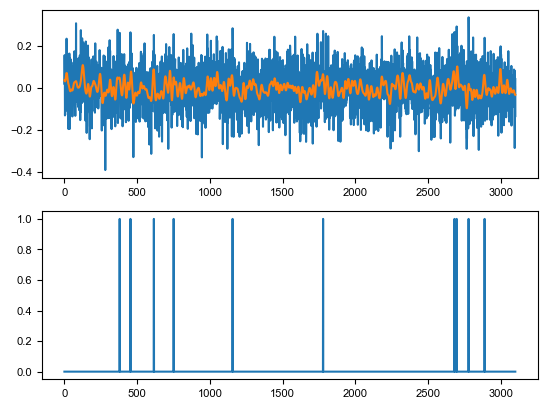

In [74]:
preview_i_trial = 0
preview_i_roi = 0

plt.figure()
plt.subplot(2,1,1)
plt.plot(dFF_s[preview_i_roi, preview_i_trial,:])
plt.plot(roi_subthd_dFFs[preview_i_roi, preview_i_trial,:])
plt.subplot(2,1,2)
plt.plot(roi_spike_events[preview_i_roi, preview_i_trial,:])
plt.show()


In [75]:
roi_spike_dFFs = np.zeros(roi_spike_events.shape)
roi_spike_dFFs[roi_spike_events > 0] = dFF_s[roi_spike_events > 0]

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 21.61 s


In [76]:
dff_ffts = np.fft.fft(dFF_s, axis = -1)
dff_fft_freq = np.fft.fftfreq(n = dFF_s.shape[-1], d = ms_to_s * time_per_frame_ms)

subthd_ffts = np.fft.fft(roi_subthd_dFFs, axis = -1)
subthd_fft_freq = np.fft.fftfreq(n = roi_subthd_dFFs.shape[-1], d = ms_to_s * time_per_frame_ms)

suprathd_ffts = np.fft.fft(roi_spike_events, axis = -1)
# suprathd_ffts = np.fft.fft(roi_spike_dFFs, axis = -1)
suprathd_fft_freq = np.fft.fftfreq(n = roi_spike_events.shape[-1], d = ms_to_s * time_per_frame_ms)

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 23.36 s


In [77]:
roi_avg_spike_rate = np.mean(roi_spike_events, axis = 1)
trial_avg_spike_rate = np.mean(roi_spike_events, axis = 0)
tot_avg_spike_rate = np.mean(roi_spike_events, axis = (0,1))

roi_avg_dFF = np.mean(dFF_s, axis = 1)
trial_avg_dFF = np.mean(dFF_s, axis = 0)
tot_avg_dFF = np.mean(dFF_s, axis = (0,1))

print(roi_avg_spike_rate.shape)
print(trial_avg_spike_rate.shape)
print(tot_avg_spike_rate.shape)

print(roi_avg_dFF.shape)
print(trial_avg_dFF.shape)
print(tot_avg_dFF.shape)

SAVE_PROGRESS(HISTORY_FILEPATH)

(180, 3100)
(37, 3100)
(3100,)
(180, 3100)
(37, 3100)
(3100,)
Time since last sync = 23.49 s


In [78]:
roi_avg_spike_rate_ffts = np.fft.fft(roi_avg_spike_rate, axis = -1)
roi_avg_spike_rate_fftfreqs = np.fft.fftfreq(n = roi_avg_spike_rate.shape[-1], d = ms_to_s * time_per_frame_ms)

trial_avg_spike_rate_ffts = np.fft.fft(trial_avg_spike_rate, axis = -1)
trial_avg_spike_rate_fftfreqs = np.fft.fftfreq(n = trial_avg_spike_rate.shape[-1], d = ms_to_s * time_per_frame_ms)

tot_avg_spike_rate_ffts = np.fft.fft(tot_avg_spike_rate)
tot_avg_spike_rate_fftfreqs = np.fft.fftfreq(n = tot_avg_spike_rate.shape[-1], d = ms_to_s * time_per_frame_ms)

roi_avg_dFF_ffts = np.fft.fft(roi_avg_dFF, axis = -1)
roi_avg_dFF_fftfreqs = np.fft.fftfreq(n = roi_avg_dFF.shape[-1], d = ms_to_s * time_per_frame_ms)

trial_avg_dFF_ffts = np.fft.fft(trial_avg_dFF, axis = -1)
trial_avg_dFF_fftfreqs = np.fft.fftfreq(n = trial_avg_dFF.shape[-1], d = ms_to_s * time_per_frame_ms)

tot_avg_dFF_ffts = np.fft.fft(tot_avg_dFF, axis = -1)
tot_avg_dFF_fftfreqs = np.fft.fftfreq(n = tot_avg_dFF.shape[-1], d = ms_to_s * time_per_frame_ms)

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 23.58 s


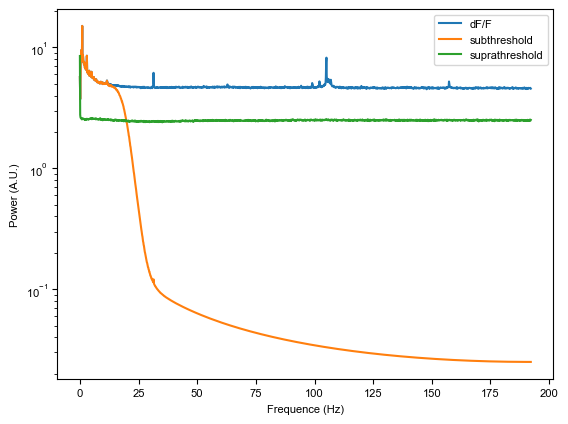

Time since last sync = 24.63 s


In [79]:
plot_x_range = [0, 200]

plt.figure()
plot_mask = np.logical_and(dff_fft_freq >= plot_x_range[0], dff_fft_freq <= plot_x_range[1])
plt.plot(dff_fft_freq[plot_mask], 
         np.mean(np.abs(dff_ffts), axis = (0,1))[plot_mask],
         label = "dF/F",
        )

plot_mask = np.logical_and(subthd_fft_freq >= plot_x_range[0], subthd_fft_freq <= plot_x_range[1])
plt.plot(subthd_fft_freq[plot_mask], 
         np.mean(np.abs(subthd_ffts), axis = (0,1))[plot_mask],
         label = "subthreshold",
        )

plot_mask = np.logical_and(suprathd_fft_freq >= plot_x_range[0], suprathd_fft_freq <= plot_x_range[1])
plt.plot(suprathd_fft_freq[plot_mask], 
         np.mean(np.abs(suprathd_ffts), axis = (0,1))[plot_mask],
        label = "suprathreshold",
        )
plt.legend()
plt.xlabel("Frequence (Hz)")
plt.ylabel("Power (A.U.)")

plt.yscale("log")
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

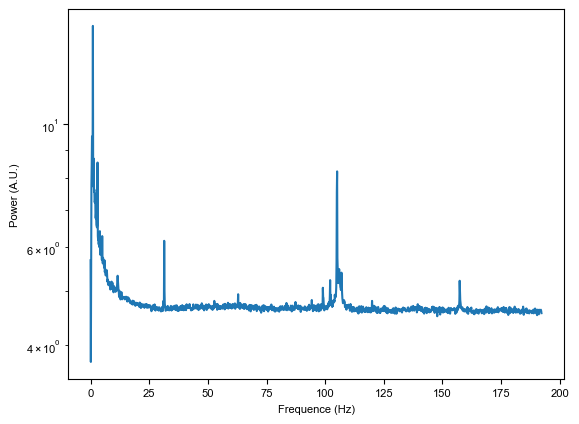

Time since last sync = 25.03 s


In [80]:
%matplotlib inline

plot_x_range = [0, 200]

plot_fft_trace = np.mean(np.abs(dff_ffts), axis = (0,1))
plot_fft_freqs = dff_fft_freq

plt.figure()
plot_mask = np.logical_and(plot_fft_freqs >= plot_x_range[0], plot_fft_freqs <= plot_x_range[1])
plt.plot(plot_fft_freqs[plot_mask], 
         plot_fft_trace[plot_mask],
        )
plt.xlabel("Frequence (Hz)")
plt.ylabel("Power (A.U.)")
plt.yscale("log")
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

[  0.62034739   0.99255583   1.24069479   1.61290323   1.98511166
   2.3573201    2.97766749   3.34987593   3.59801489   3.97022333
   4.21836228   4.46650124   4.96277916   5.33498759   5.95533499
   6.20347395   6.94789082   7.32009926   7.81637717   8.18858561
   8.56079404   8.93300248   9.30521092   9.92555831  10.54590571
  11.04218362  11.53846154  12.28287841  31.38957816  99.00744417
 102.10918114 105.08684864 105.70719603 105.95533499 106.32754342
 106.94789082 157.32009926]


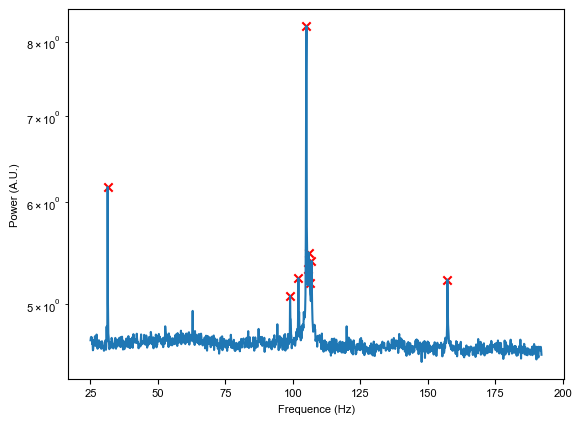

Time since last sync = 25.44 s


In [81]:
# find peak in fft spectrum

input_fft_trace = np.mean(np.abs(dff_ffts), axis = (0,1))
input_fft_freqs = dff_fft_freq

fft_trace_peaks = signal.find_peaks(
    input_fft_trace,
    height = 5,
    # threshold = 0.1,
)

# print(fft_trace_peaks)

fft_peak_ys = input_fft_trace[fft_trace_peaks[0]]
fft_peak_freqs = input_fft_freqs[fft_trace_peaks[0]]

print(fft_peak_freqs[fft_peak_freqs >= 0])

plot_x_range = [25, 200]

plt.figure()
plot_mask = np.logical_and(input_fft_freqs >= plot_x_range[0], input_fft_freqs <= plot_x_range[1])
plt.plot(input_fft_freqs[plot_mask], 
         input_fft_trace[plot_mask],
        )
plot_mask = np.logical_and(fft_peak_freqs >= plot_x_range[0], fft_peak_freqs <= plot_x_range[1])
plt.scatter(
    x = fft_peak_freqs[plot_mask],
    y = fft_peak_ys[plot_mask],
    marker = "x",
    color = "red",
)
plt.xlabel("Frequence (Hz)")
plt.ylabel("Power (A.U.)")
plt.yscale("log")
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [82]:
# create dst directory

dst_plot_subdir_path = os.path.join(dst_dir_path, dst_plot_subdir_name)

if not os.path.isdir(dst_plot_subdir_path):
    os.makedirs(dst_plot_subdir_path)

print(dst_plot_subdir_path)

SAVE_PROGRESS(HISTORY_FILEPATH)

F:\2023-08-31\M375_JEDI2P\FOV01\Group03\StatsAnalysisSubtresholds_Ver06_FromVer01_20Hz5OrderBW_CorrectMeanTiming\fft_analysis_makefigs
Time since last sync = 25.47 s


In [83]:
# save data to hdf5 file
dst_hdf5_file_name = "fft_result.hdf5"
dst_hdf5_file_path = os.path.join(dst_plot_subdir_path, dst_hdf5_file_name)

with h5py.File(dst_hdf5_file_path, "w") as hdf5_file:
    hdf5_file.create_dataset("src_hdf5_file_path", data = src_hdf5_file_path)
    hdf5_file.create_dataset("roi_spike_dFFs", data = roi_spike_dFFs)
    hdf5_file.create_dataset("dff_ffts", data = dff_ffts)
    hdf5_file.create_dataset("dff_fft_freq", data = dff_fft_freq)
    hdf5_file.create_dataset("subthd_ffts", data = subthd_ffts)
    hdf5_file.create_dataset("subthd_fft_freq", data = subthd_fft_freq)
    hdf5_file.create_dataset("suprathd_ffts", data = suprathd_ffts)
    hdf5_file.create_dataset("suprathd_fft_freq", data = suprathd_fft_freq)
    hdf5_file.create_dataset("roi_avg_spike_rate", data = roi_avg_spike_rate)
    hdf5_file.create_dataset("trial_avg_spike_rate", data = trial_avg_spike_rate)
    hdf5_file.create_dataset("tot_avg_spike_rate", data = tot_avg_spike_rate)
    hdf5_file.create_dataset("roi_avg_dFF", data = roi_avg_dFF)
    hdf5_file.create_dataset("trial_avg_dFF", data = trial_avg_dFF)
    hdf5_file.create_dataset("tot_avg_dFF", data = tot_avg_dFF)
    hdf5_file.create_dataset("roi_avg_spike_rate_ffts", data = roi_avg_spike_rate_ffts)
    hdf5_file.create_dataset("roi_avg_spike_rate_fftfreqs", data = roi_avg_spike_rate_fftfreqs)
    hdf5_file.create_dataset("trial_avg_spike_rate_ffts", data = trial_avg_spike_rate_ffts)
    hdf5_file.create_dataset("trial_avg_spike_rate_fftfreqs", data = trial_avg_spike_rate_fftfreqs)
    hdf5_file.create_dataset("tot_avg_spike_rate_ffts", data = tot_avg_spike_rate_ffts)
    hdf5_file.create_dataset("tot_avg_spike_rate_fftfreqs", data = tot_avg_spike_rate_fftfreqs)
    hdf5_file.create_dataset("roi_avg_dFF_ffts", data = roi_avg_dFF_ffts)
    hdf5_file.create_dataset("roi_avg_dFF_fftfreqs", data = roi_avg_dFF_fftfreqs)
    hdf5_file.create_dataset("trial_avg_dFF_ffts", data = trial_avg_dFF_ffts)
    hdf5_file.create_dataset("trial_avg_dFF_fftfreqs", data = trial_avg_dFF_fftfreqs)
    hdf5_file.create_dataset("tot_avg_dFF_ffts", data = tot_avg_dFF_ffts)
    hdf5_file.create_dataset("tot_avg_dFF_fftfreqs", data = tot_avg_dFF_fftfreqs)

print(dst_hdf5_file_path)

SAVE_PROGRESS(HISTORY_FILEPATH)

F:\2023-08-31\M375_JEDI2P\FOV01\Group03\StatsAnalysisSubtresholds_Ver06_FromVer01_20Hz5OrderBW_CorrectMeanTiming\fft_analysis_makefigs\fft_result.hdf5
Time since last sync = 31.25 s


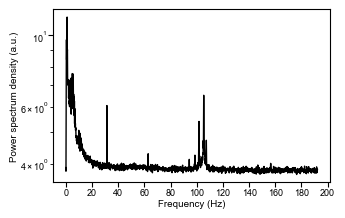

Time since last sync = 91.76 s


In [18]:
# create (nice) fft figure without zoom-in view 

plot_x_range = [0, 200]

plot_fft_trace = np.fft.fftshift(np.mean(np.abs(dff_ffts), axis = (0,1)))
plot_fft_freqs = np.fft.fftshift(dff_fft_freq)

plot_xlim = [0, 200]
plot_x_ticks = np.arange(plot_x_range[0], plot_x_range[-1] + 1, 20)
plot_x_ticklabels = plot_x_ticks
# plot_x_ticks = np.array([0, 10, 30, 80, 200])
# plot_x_ticklabels = plot_x_ticks

fig_width = letter_paper_size_inch[0] * paper_to_illustrator_ratio[0] * (1/2)
fig_height = letter_paper_size_inch[1] * paper_to_illustrator_ratio[1] * (1/4)

plt.figure(figsize = (fig_width, fig_height))
plot_mask = np.logical_and(plot_fft_freqs >= plot_x_range[0], plot_fft_freqs <= plot_x_range[1])
plt.plot(plot_fft_freqs[plot_mask], 
         plot_fft_trace[plot_mask],
         color = "black",
         linewidth = 1,
        )
# plt.xlim(plot_xlim)
plt.xticks(
    ticks = plot_x_ticks,
    labels = plot_x_ticklabels)
plt.yscale("log")

plt.tick_params(
    axis='both', which='major', 
    labelsize=plot_numeric_label_font_size, 
    pad = 1)
plt.tick_params(
    axis='both', which='minor', 
    labelsize=plot_numeric_label_font_size,
    pad = 1)

plt.xlabel(
    "Frequency (Hz)", 
    fontsize = plot_axis_label_font_size,
    labelpad = 1)
plt.ylabel("Power spectrum density (a.u.)", 
    fontsize = plot_axis_label_font_size,
    labelpad = 1)
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


pickle dump to: M:\2023-05-11\M347\FOV02\Group01\StatsAnalysisSubtresholds_Ver06_FromVer01p6_20Hz5OrderBW_CorrectMeanTiming\fft_analysis_makefigs\trace_fft_all_roi_trial_plot_linear_inset.pickle
plot saved to: M:\2023-05-11\M347\FOV02\Group01\StatsAnalysisSubtresholds_Ver06_FromVer01p6_20Hz5OrderBW_CorrectMeanTiming\fft_analysis_makefigs\trace_fft_all_roi_trial_plot_linear_inset.pdf


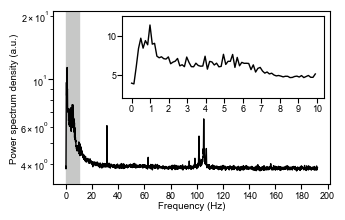

Time since last sync = 172.67 s


In [26]:
# create (nice) fft figure with zoom-in view 

plot_x_range = [0, 200]

plot_xlim = [0, 200]

# plot_ylim = [3.4,22] # for M377
plot_ylim = [3.2,21] # for M347
# plot_ylim = [5.7,22] # for M374
# plot_ylim = [3.6,26] # for M375

# plot_inset_ylim = [3,20] # for M377
plot_inset_ylim = [2,12.5] # for M347
# plot_inset_ylim = [5,12.5] # for M374
# plot_inset_ylim = [3,16] # for M375

plot_x_ticks = np.arange(plot_x_range[0], plot_x_range[-1] + 1, 20)
plot_x_ticklabels = plot_x_ticks
# plot_x_ticks = np.array([0, 10, 30, 80, 200])
# plot_x_ticklabels = plot_x_ticks

plot_inset_yticks = np.arange(
    int(2*np.ceil(plot_inset_ylim[0]/2)),
    plot_inset_ylim[1],
    2)

plot_zoom_x_range = [0,10]

plot_zoom_inset_x0 = 0.25
plot_zoom_inset_y0 = 0.5
plot_zoom_inset_width = 0.98 - plot_zoom_inset_x0
plot_zoom_inset_height = 0.97 - plot_zoom_inset_y0

plot_zoom_x_ticks = np.arange(plot_zoom_x_range[0], plot_zoom_x_range[-1] + 1, 1)
plot_zoom_x_ticklabels = plot_zoom_x_ticks

plot_fft_trace = np.fft.fftshift(np.mean(np.abs(dff_ffts), axis = (0,1)))
plot_fft_freqs = np.fft.fftshift(dff_fft_freq)

fig_width = letter_paper_size_inch[0] * paper_to_illustrator_ratio[0] * (1/2)
fig_height = letter_paper_size_inch[1] * paper_to_illustrator_ratio[1] * (1/4)

dst_figure_name = "trace_fft_all_roi_trial_plot_linear_inset"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

fig = plt.figure(figsize = (fig_width, fig_height))
plot_mask = np.logical_and(plot_fft_freqs >= plot_x_range[0], plot_fft_freqs <= plot_x_range[1])
plt.plot(plot_fft_freqs[plot_mask], 
         plot_fft_trace[plot_mask],
         color = "black",
         linewidth = 1,
         zorder = 1,
        )
plt.axvspan(
    xmin = plot_zoom_x_range[0],
    xmax = plot_zoom_x_range[1],
    color = "#c7c8c7",
    zorder = 0)

plt.ylim(plot_ylim)

# plt.xlim(plot_xlim)
# plt.ylim([np.min(plot_fft_trace)*(0.8), np.max(plot_fft_trace)*2])

plt.xticks(
    ticks = plot_x_ticks,
    labels = plot_x_ticklabels)
plt.yscale("log")

plt.tick_params(
    axis='both', which='major', 
    labelsize=plot_numeric_label_font_size, 
    pad = 1)
plt.tick_params(
    axis='both', which='minor', 
    labelsize=plot_numeric_label_font_size,
    pad = 1)

plt.xlabel(
    "Frequency (Hz)", 
    fontsize = plot_axis_label_font_size,
    labelpad = 1)
plt.ylabel("Power spectrum density (a.u.)", 
    fontsize = plot_axis_label_font_size,
    labelpad = 1)

plot_ax = plt.gca()
inset_ax = plot_ax.inset_axes(
    [plot_zoom_inset_x0, plot_zoom_inset_y0, plot_zoom_inset_width, plot_zoom_inset_height],
)
plot_inset_mask = np.logical_and(plot_fft_freqs >= plot_zoom_x_range[0], 
                                 plot_fft_freqs <= plot_zoom_x_range[1])
inset_ax.plot(
    plot_fft_freqs[plot_inset_mask], 
    plot_fft_trace[plot_inset_mask],
    color = "black",
    linewidth = 1,    
)
inset_ax.set_ylim(plot_inset_ylim)
inset_ax.set_xticks(plot_zoom_x_ticks)
inset_ax.set_xticklabels(plot_zoom_x_ticklabels)
# inset_ax.set_yticks(plot_inset_yticks)
# inset_ax.set_yscale("log")
inset_ax.tick_params(
        axis='both', which='major', 
        labelsize=plot_numeric_label_font_size, 
        pad = 1)
inset_ax.tick_params(
        axis='both', which='minor', 
        labelsize=plot_numeric_label_font_size,
        pad = 1)

fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight', dpi = 600)
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

print("pickle dump to: " + dst_pkl_figure_path)

%notebook $dst_notebook_path

print("plot saved to: " + dst_pdf_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


pickle dump to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\fft_analysis_makefigs\trace_fft_trial13_roi_avg_plot_linear_inset.pickle
plot saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\fft_analysis_makefigs\trace_fft_trial13_roi_avg_plot_linear_inset.pdf


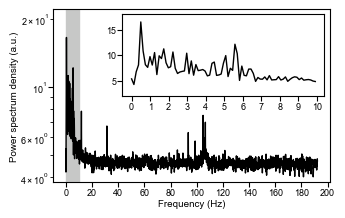

Time since last sync = 275.75 s


In [87]:
# create (nice) fft figure with zoom-in view for a single trial

plot_x_range = [0, 200]

plot_xlim = [0, 200]
plot_ylim = [3.8,22]

plot_inset_ylim = [2,18] # for M377

plot_x_ticks = np.arange(plot_x_range[0], plot_x_range[-1] + 1, 20)
plot_x_ticklabels = plot_x_ticks
# plot_x_ticks = np.array([0, 10, 30, 80, 200])
# plot_x_ticklabels = plot_x_ticks

plot_zoom_x_range = [0,10]

plot_zoom_inset_x0 = 0.25
plot_zoom_inset_y0 = 0.5
plot_zoom_inset_width = 0.98 - plot_zoom_inset_x0
plot_zoom_inset_height = 0.97 - plot_zoom_inset_y0

plot_zoom_x_ticks = np.arange(plot_zoom_x_range[0], plot_zoom_x_range[-1] + 1, 1)
plot_zoom_x_ticklabels = plot_zoom_x_ticks

plot_trial_idx = 13

plot_fft_trace = np.mean(np.abs(dff_ffts), axis = 0)[plot_trial_idx, :]
plot_fft_freqs = dff_fft_freq

plot_fft_trace = np.fft.fftshift(plot_fft_trace)
plot_fft_freqs = np.fft.fftshift(plot_fft_freqs)

fig_width = letter_paper_size_inch[0] * paper_to_illustrator_ratio[0] * (1/2)
fig_height = letter_paper_size_inch[1] * paper_to_illustrator_ratio[1] * (1/4)

dst_figure_name = f"trace_fft_trial{plot_trial_idx}_roi_avg_plot_linear_inset"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

fig = plt.figure(figsize = (fig_width, fig_height))
plot_mask = np.logical_and(plot_fft_freqs >= plot_x_range[0], plot_fft_freqs <= plot_x_range[1])
plt.plot(plot_fft_freqs[plot_mask], 
         plot_fft_trace[plot_mask],
         color = "black",
         linewidth = 1,
         zorder = 1,
        )
plt.axvspan(
    xmin = plot_zoom_x_range[0],
    xmax = plot_zoom_x_range[1],
    color = "#c7c8c7",
    zorder = 0)

# plt.xlim(plot_xlim)
plt.ylim(plot_ylim)

plt.xticks(
    ticks = plot_x_ticks,
    labels = plot_x_ticklabels)
plt.yscale("log")

plt.tick_params(
    axis='both', which='major', 
    labelsize=plot_numeric_label_font_size, 
    pad = 1)
plt.tick_params(
    axis='both', which='minor', 
    labelsize=plot_numeric_label_font_size,
    pad = 1)

plt.xlabel(
    "Frequency (Hz)", 
    fontsize = plot_axis_label_font_size,
    labelpad = 1)
plt.ylabel("Power spectrum density (a.u.)", 
    fontsize = plot_axis_label_font_size,
    labelpad = 1)

plot_ax = plt.gca()
inset_ax = plot_ax.inset_axes(
    [plot_zoom_inset_x0, plot_zoom_inset_y0, plot_zoom_inset_width, plot_zoom_inset_height],
)
plot_inset_mask = np.logical_and(plot_fft_freqs >= plot_zoom_x_range[0], 
                                 plot_fft_freqs <= plot_zoom_x_range[1])
inset_ax.plot(
    plot_fft_freqs[plot_inset_mask], 
    plot_fft_trace[plot_inset_mask],
    color = "black",
    linewidth = 1,    
)
inset_ax.set_ylim(plot_inset_ylim)
inset_ax.set_xticks(plot_zoom_x_ticks)
inset_ax.set_xticklabels(plot_zoom_x_ticklabels)
# inset_ax.set_yscale("log")
inset_ax.tick_params(
        axis='both', which='major', 
        labelsize=plot_numeric_label_font_size, 
        pad = 1)
inset_ax.tick_params(
        axis='both', which='minor', 
        labelsize=plot_numeric_label_font_size,
        pad = 1)

fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight', dpi = 600)
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

print("pickle dump to: " + dst_pkl_figure_path)

%notebook $dst_notebook_path

print("plot saved to: " + dst_pdf_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)